# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-2.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.2)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [10]:
len(train_set), len(val_set)

(9999, 2499)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-2/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [20]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 40/40 [00:11<00:00,  3.36it/s, Epoch=1, LR=6.13e-5, Valid_Loss=21.7]


Valid RMSE: 21.77138900756836
Valid MAE: 17.276464462280273
Valid SMAPE: 0.15675705671310425
Validation Loss Improved (inf ---> 21.77138900756836)



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=2, LR=5.71e-6, Valid_Loss=16.6]


Valid RMSE: 16.635040283203125
Valid MAE: 13.246561050415039
Valid SMAPE: 0.12006144970655441
Validation Loss Improved (21.77138900756836 ---> 16.635040283203125)



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=3, LR=2.02e-5, Valid_Loss=16.8]


Valid RMSE: 16.84974479675293
Valid MAE: 13.326977729797363
Valid SMAPE: 0.12006837874650955



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=4, LR=8.21e-5, Valid_Loss=17.8]


Valid RMSE: 17.97882652282715
Valid MAE: 13.643779754638672
Valid SMAPE: 0.12508827447891235



100%|██████████| 40/40 [00:09<00:00,  4.43it/s, Epoch=5, LR=9.46e-5, Valid_Loss=15.8]


Valid RMSE: 15.855165481567383
Valid MAE: 12.527848243713379
Valid SMAPE: 0.11395758390426636
Validation Loss Improved (16.635040283203125 ---> 15.855165481567383)



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=6, LR=3.82e-5, Valid_Loss=15]  


Valid RMSE: 15.017401695251465
Valid MAE: 11.876803398132324
Valid SMAPE: 0.10790472477674484
Validation Loss Improved (15.855165481567383 ---> 15.017401695251465)



100%|██████████| 40/40 [00:09<00:00,  4.29it/s, Epoch=7, LR=1.02e-6, Valid_Loss=14.9]


Valid RMSE: 14.999368667602539
Valid MAE: 11.717402458190918
Valid SMAPE: 0.10769320279359818
Validation Loss Improved (15.017401695251465 ---> 14.999368667602539)



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=8, LR=4.12e-5, Valid_Loss=15.7]


Valid RMSE: 15.763416290283203
Valid MAE: 12.21083927154541
Valid SMAPE: 0.1127995029091835



100%|██████████| 40/40 [00:08<00:00,  4.57it/s, Epoch=9, LR=9.59e-5, Valid_Loss=17.5]


Valid RMSE: 17.663671493530273
Valid MAE: 13.554276466369629
Valid SMAPE: 0.12316564470529556



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=10, LR=7.96e-5, Valid_Loss=15.2]


Valid RMSE: 15.341757774353027
Valid MAE: 11.791144371032715
Valid SMAPE: 0.10859749466180801



100%|██████████| 40/40 [00:09<00:00,  4.11it/s, Epoch=11, LR=1.78e-5, Valid_Loss=14.4]


Valid RMSE: 14.452005386352539
Valid MAE: 11.372456550598145
Valid SMAPE: 0.10432781279087067
Validation Loss Improved (14.999368667602539 ---> 14.452005386352539)



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=12, LR=7.12e-6, Valid_Loss=14.5]


Valid RMSE: 14.500763893127441
Valid MAE: 11.332024574279785
Valid SMAPE: 0.10313091427087784



100%|██████████| 40/40 [00:08<00:00,  4.54it/s, Epoch=13, LR=6.43e-5, Valid_Loss=14.1]


Valid RMSE: 14.196822166442871
Valid MAE: 11.025829315185547
Valid SMAPE: 0.10095304995775223
Validation Loss Improved (14.452005386352539 ---> 14.196822166442871)



100%|██████████| 40/40 [00:09<00:00,  4.08it/s, Epoch=14, LR=9.99e-5, Valid_Loss=14.8]


Valid RMSE: 14.876744270324707
Valid MAE: 11.489458084106445
Valid SMAPE: 0.10562193393707275



100%|██████████| 40/40 [00:08<00:00,  4.52it/s, Epoch=15, LR=5.82e-5, Valid_Loss=14.7]


Valid RMSE: 14.781488418579102
Valid MAE: 11.599967956542969
Valid SMAPE: 0.10521746426820755



100%|██████████| 40/40 [00:08<00:00,  4.53it/s, Epoch=16, LR=4.48e-6, Valid_Loss=14.2]


Valid RMSE: 14.306463241577148
Valid MAE: 11.081995964050293
Valid SMAPE: 0.10204072296619415



100%|██████████| 40/40 [00:08<00:00,  4.77it/s, Epoch=17, LR=2.27e-5, Valid_Loss=14]  


Valid RMSE: 14.089387893676758
Valid MAE: 11.078543663024902
Valid SMAPE: 0.10089495033025742
Validation Loss Improved (14.196822166442871 ---> 14.089387893676758)



100%|██████████| 40/40 [00:08<00:00,  4.65it/s, Epoch=18, LR=8.44e-5, Valid_Loss=14.6]


Valid RMSE: 14.678790092468262
Valid MAE: 11.366262435913086
Valid SMAPE: 0.10425432026386261



100%|██████████| 40/40 [00:09<00:00,  4.12it/s, Epoch=19, LR=9.31e-5, Valid_Loss=16.4]


Valid RMSE: 16.578542709350586
Valid MAE: 12.492203712463379
Valid SMAPE: 0.11416880041360855



100%|██████████| 40/40 [00:08<00:00,  4.46it/s, Epoch=20, LR=3.52e-5, Valid_Loss=14.5]


Valid RMSE: 14.574227333068848
Valid MAE: 11.404823303222656
Valid SMAPE: 0.10327526926994324



100%|██████████| 40/40 [00:09<00:00,  4.12it/s, Epoch=21, LR=1.22e-6, Valid_Loss=13.8]


Valid RMSE: 13.91867446899414
Valid MAE: 10.737785339355469
Valid SMAPE: 0.09894480556249619
Validation Loss Improved (14.089387893676758 ---> 13.91867446899414)



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=22, LR=4.43e-5, Valid_Loss=14.8]


Valid RMSE: 14.86451244354248
Valid MAE: 11.739054679870605
Valid SMAPE: 0.10546061396598816



100%|██████████| 40/40 [00:08<00:00,  4.71it/s, Epoch=23, LR=9.71e-5, Valid_Loss=14.6]


Valid RMSE: 14.65334415435791
Valid MAE: 11.378267288208008
Valid SMAPE: 0.10481876134872437



100%|██████████| 40/40 [00:09<00:00,  4.05it/s, Epoch=24, LR=7.7e-5, Valid_Loss=15]  


Valid RMSE: 15.055813789367676
Valid MAE: 11.93186092376709
Valid SMAPE: 0.1069885715842247



100%|██████████| 40/40 [00:08<00:00,  4.52it/s, Epoch=25, LR=1.55e-5, Valid_Loss=13.4]


Valid RMSE: 13.429350852966309
Valid MAE: 10.58006477355957
Valid SMAPE: 0.09788220375776291
Validation Loss Improved (13.91867446899414 ---> 13.429350852966309)



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=26, LR=8.71e-6, Valid_Loss=14.1]


Valid RMSE: 14.206633567810059
Valid MAE: 10.93450927734375
Valid SMAPE: 0.1002708375453949



100%|██████████| 40/40 [00:09<00:00,  4.11it/s, Epoch=27, LR=6.73e-5, Valid_Loss=13.9]


Valid RMSE: 13.964112281799316
Valid MAE: 10.922136306762695
Valid SMAPE: 0.10099322348833084



100%|██████████| 40/40 [00:08<00:00,  4.45it/s, Epoch=28, LR=9.96e-5, Valid_Loss=14.6]


Valid RMSE: 14.702604293823242
Valid MAE: 11.352564811706543
Valid SMAPE: 0.1037115529179573



100%|██████████| 40/40 [00:09<00:00,  4.22it/s, Epoch=29, LR=5.52e-5, Valid_Loss=14]  


Valid RMSE: 14.046435356140137
Valid MAE: 10.993828773498535
Valid SMAPE: 0.10056541860103607



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=30, LR=3.42e-6, Valid_Loss=13.3]


Valid RMSE: 13.443965911865234
Valid MAE: 10.424549102783203
Valid SMAPE: 0.09641426056623459



100%|██████████| 40/40 [00:09<00:00,  4.20it/s, Epoch=31, LR=2.53e-5, Valid_Loss=14.1]


Valid RMSE: 14.219917297363281
Valid MAE: 10.99025821685791
Valid SMAPE: 0.10142785310745239



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=32, LR=8.66e-5, Valid_Loss=13.7]


Valid RMSE: 13.757572174072266
Valid MAE: 10.798012733459473
Valid SMAPE: 0.10095877945423126



100%|██████████| 40/40 [00:09<00:00,  4.36it/s, Epoch=33, LR=9.14e-5, Valid_Loss=13.9]


Valid RMSE: 14.01233959197998
Valid MAE: 10.74016284942627
Valid SMAPE: 0.09874984622001648



100%|██████████| 40/40 [00:09<00:00,  4.20it/s, Epoch=34, LR=3.23e-5, Valid_Loss=13.5]


Valid RMSE: 13.591567993164062
Valid MAE: 10.606104850769043
Valid SMAPE: 0.0981951579451561



100%|██████████| 40/40 [00:09<00:00,  4.06it/s, Epoch=35, LR=1.61e-6, Valid_Loss=13.4]


Valid RMSE: 13.417624473571777
Valid MAE: 10.534611701965332
Valid SMAPE: 0.0972725972533226
Validation Loss Improved (13.429350852966309 ---> 13.417624473571777)



100%|██████████| 40/40 [00:09<00:00,  4.24it/s, Epoch=36, LR=4.74e-5, Valid_Loss=14.3]


Valid RMSE: 14.376319885253906
Valid MAE: 11.149327278137207
Valid SMAPE: 0.10202676057815552



100%|██████████| 40/40 [00:08<00:00,  4.49it/s, Epoch=37, LR=9.8e-5, Valid_Loss=14.1]


Valid RMSE: 14.17541217803955
Valid MAE: 10.85434341430664
Valid SMAPE: 0.099322110414505



100%|██████████| 40/40 [00:09<00:00,  4.30it/s, Epoch=38, LR=7.43e-5, Valid_Loss=14]  


Valid RMSE: 14.100210189819336
Valid MAE: 10.885309219360352
Valid SMAPE: 0.10128074884414673



100%|██████████| 40/40 [00:09<00:00,  4.12it/s, Epoch=39, LR=1.34e-5, Valid_Loss=13.4]


Valid RMSE: 13.420063018798828
Valid MAE: 10.348237991333008
Valid SMAPE: 0.09598078578710556



100%|██████████| 40/40 [00:09<00:00,  4.34it/s, Epoch=40, LR=1.05e-5, Valid_Loss=13.2]


Valid RMSE: 13.317753791809082
Valid MAE: 10.379526138305664
Valid SMAPE: 0.09529522061347961
Validation Loss Improved (13.417624473571777 ---> 13.317753791809082)



100%|██████████| 40/40 [00:08<00:00,  4.60it/s, Epoch=41, LR=7.02e-5, Valid_Loss=13.7]


Valid RMSE: 13.820457458496094
Valid MAE: 10.777556419372559
Valid SMAPE: 0.0999094620347023



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=42, LR=9.91e-5, Valid_Loss=13.7]


Valid RMSE: 13.788386344909668
Valid MAE: 10.655529022216797
Valid SMAPE: 0.09840349107980728



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=43, LR=5.21e-5, Valid_Loss=13.5]


Valid RMSE: 13.572760581970215
Valid MAE: 10.384858131408691
Valid SMAPE: 0.0964859277009964



100%|██████████| 40/40 [00:09<00:00,  4.44it/s, Epoch=44, LR=2.56e-6, Valid_Loss=13.2]


Valid RMSE: 13.205270767211914
Valid MAE: 10.242228507995605
Valid SMAPE: 0.09527494013309479
Validation Loss Improved (13.317753791809082 ---> 13.205270767211914)



100%|██████████| 40/40 [00:10<00:00,  3.86it/s, Epoch=45, LR=2.8e-5, Valid_Loss=13.7]


Valid RMSE: 13.807053565979004
Valid MAE: 10.861737251281738
Valid SMAPE: 0.09914345294237137



100%|██████████| 40/40 [00:08<00:00,  4.82it/s, Epoch=46, LR=8.86e-5, Valid_Loss=13.6]


Valid RMSE: 13.73223876953125
Valid MAE: 10.620442390441895
Valid SMAPE: 0.09762494266033173



100%|██████████| 40/40 [00:08<00:00,  4.54it/s, Epoch=47, LR=8.96e-5, Valid_Loss=14.2]


Valid RMSE: 14.239215850830078
Valid MAE: 11.108670234680176
Valid SMAPE: 0.10119403153657913



100%|██████████| 40/40 [00:08<00:00,  4.62it/s, Epoch=48, LR=2.94e-5, Valid_Loss=13.3]


Valid RMSE: 13.37420654296875
Valid MAE: 10.347331047058105
Valid SMAPE: 0.09517186135053635



100%|██████████| 40/40 [00:08<00:00,  4.51it/s, Epoch=49, LR=2.19e-6, Valid_Loss=13.4]


Valid RMSE: 13.468239784240723
Valid MAE: 10.422262191772461
Valid SMAPE: 0.0968485027551651



100%|██████████| 40/40 [00:09<00:00,  4.07it/s, Epoch=50, LR=5.05e-5, Valid_Loss=14]  


Valid RMSE: 14.127965927124023
Valid MAE: 10.789274215698242
Valid SMAPE: 0.09924505650997162



100%|██████████| 40/40 [00:09<00:00,  4.42it/s, Epoch=51, LR=9.88e-5, Valid_Loss=13.7]


Valid RMSE: 13.739011764526367
Valid MAE: 10.609134674072266
Valid SMAPE: 0.09779166430234909



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=52, LR=7.16e-5, Valid_Loss=14.1]


Valid RMSE: 14.117597579956055
Valid MAE: 11.202963829040527
Valid SMAPE: 0.1014837697148323



100%|██████████| 40/40 [00:08<00:00,  4.55it/s, Epoch=53, LR=1.14e-5, Valid_Loss=13]  


Valid RMSE: 13.120747566223145
Valid MAE: 10.262197494506836
Valid SMAPE: 0.09554962813854218
Validation Loss Improved (13.205270767211914 ---> 13.120747566223145)



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=54, LR=1.24e-5, Valid_Loss=13.2]


Valid RMSE: 13.315580368041992
Valid MAE: 10.368363380432129
Valid SMAPE: 0.09637410938739777



100%|██████████| 40/40 [00:09<00:00,  4.22it/s, Epoch=55, LR=7.3e-5, Valid_Loss=14.6]


Valid RMSE: 14.761946678161621
Valid MAE: 11.269564628601074
Valid SMAPE: 0.10355480015277863



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=56, LR=9.84e-5, Valid_Loss=13.5]


Valid RMSE: 13.57609748840332
Valid MAE: 10.449065208435059
Valid SMAPE: 0.09644326567649841



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=57, LR=4.89e-5, Valid_Loss=13.3]


Valid RMSE: 13.367426872253418
Valid MAE: 10.37466049194336
Valid SMAPE: 0.0966579020023346



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=58, LR=1.88e-6, Valid_Loss=13]  


Valid RMSE: 13.050453186035156
Valid MAE: 10.182296752929688
Valid SMAPE: 0.09446653723716736
Validation Loss Improved (13.120747566223145 ---> 13.050453186035156)



100%|██████████| 40/40 [00:09<00:00,  4.20it/s, Epoch=59, LR=3.08e-5, Valid_Loss=13.4]


Valid RMSE: 13.44774055480957
Valid MAE: 10.518574714660645
Valid SMAPE: 0.09747935086488724



100%|██████████| 40/40 [00:09<00:00,  4.27it/s, Epoch=60, LR=9.05e-5, Valid_Loss=13.5]


Valid RMSE: 13.534189224243164
Valid MAE: 10.553966522216797
Valid SMAPE: 0.09699314087629318



100%|██████████| 40/40 [00:09<00:00,  4.29it/s, Epoch=61, LR=8.76e-5, Valid_Loss=13.6]


Valid RMSE: 13.704453468322754
Valid MAE: 10.552689552307129
Valid SMAPE: 0.0969214215874672



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=62, LR=2.67e-5, Valid_Loss=12.9]


Valid RMSE: 13.015268325805664
Valid MAE: 10.08690071105957
Valid SMAPE: 0.09294848144054413
Validation Loss Improved (13.050453186035156 ---> 13.015268325805664)



100%|██████████| 40/40 [00:09<00:00,  4.24it/s, Epoch=63, LR=2.97e-6, Valid_Loss=13.1]


Valid RMSE: 13.195453643798828
Valid MAE: 10.129557609558105
Valid SMAPE: 0.09477122128009796



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=64, LR=5.36e-5, Valid_Loss=14]  


Valid RMSE: 14.101377487182617
Valid MAE: 10.926962852478027
Valid SMAPE: 0.10013390332460403



100%|██████████| 40/40 [00:09<00:00,  4.37it/s, Epoch=65, LR=9.94e-5, Valid_Loss=13.5]


Valid RMSE: 13.554156303405762
Valid MAE: 10.479652404785156
Valid SMAPE: 0.09684082120656967



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=66, LR=6.87e-5, Valid_Loss=13.1]


Valid RMSE: 13.2197904586792
Valid MAE: 10.150007247924805
Valid SMAPE: 0.09351521730422974



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=67, LR=9.56e-6, Valid_Loss=13.2]


Valid RMSE: 13.317733764648438
Valid MAE: 10.19367790222168
Valid SMAPE: 0.09484448283910751



100%|██████████| 40/40 [00:08<00:00,  4.70it/s, Epoch=68, LR=1.44e-5, Valid_Loss=13.2]


Valid RMSE: 13.204900741577148
Valid MAE: 10.213624954223633
Valid SMAPE: 0.09430554509162903



100%|██████████| 40/40 [00:09<00:00,  4.07it/s, Epoch=69, LR=7.57e-5, Valid_Loss=13.5]


Valid RMSE: 13.521791458129883
Valid MAE: 10.39764404296875
Valid SMAPE: 0.09584678709506989



100%|██████████| 40/40 [00:09<00:00,  4.05it/s, Epoch=70, LR=9.76e-5, Valid_Loss=13.5]


Valid RMSE: 13.571573257446289
Valid MAE: 10.550395965576172
Valid SMAPE: 0.09843029081821442



100%|██████████| 40/40 [00:10<00:00,  4.00it/s, Epoch=71, LR=4.58e-5, Valid_Loss=13.5]


Valid RMSE: 13.524174690246582
Valid MAE: 10.556755065917969
Valid SMAPE: 0.09794344007968903



100%|██████████| 40/40 [00:08<00:00,  4.60it/s, Epoch=72, LR=1.39e-6, Valid_Loss=13]  


Valid RMSE: 13.104710578918457
Valid MAE: 10.066893577575684
Valid SMAPE: 0.09513112902641296



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=73, LR=3.37e-5, Valid_Loss=13.7]


Valid RMSE: 13.776119232177734
Valid MAE: 10.593804359436035
Valid SMAPE: 0.0968308225274086



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=74, LR=9.23e-5, Valid_Loss=13.9]


Valid RMSE: 14.06439208984375
Valid MAE: 10.633766174316406
Valid SMAPE: 0.09879638254642487



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=75, LR=8.55e-5, Valid_Loss=13.8]


Valid RMSE: 13.916516304016113
Valid MAE: 10.807331085205078
Valid SMAPE: 0.09824132174253464



100%|██████████| 40/40 [00:09<00:00,  4.04it/s, Epoch=76, LR=2.4e-5, Valid_Loss=12.9]


Valid RMSE: 13.046927452087402
Valid MAE: 10.041398048400879
Valid SMAPE: 0.09330891817808151



100%|██████████| 40/40 [00:09<00:00,  4.15it/s, Epoch=77, LR=3.93e-6, Valid_Loss=12.8]


Valid RMSE: 12.918329238891602
Valid MAE: 9.907242774963379
Valid SMAPE: 0.09196697175502777
Validation Loss Improved (13.015268325805664 ---> 12.918329238891602)



100%|██████████| 40/40 [00:08<00:00,  4.46it/s, Epoch=78, LR=5.67e-5, Valid_Loss=13.6]


Valid RMSE: 13.698808670043945
Valid MAE: 10.67393970489502
Valid SMAPE: 0.09825240075588226



100%|██████████| 40/40 [00:09<00:00,  4.16it/s, Epoch=79, LR=9.98e-5, Valid_Loss=13.2]


Valid RMSE: 13.279853820800781
Valid MAE: 10.315706253051758
Valid SMAPE: 0.0954432412981987



100%|██████████| 40/40 [00:09<00:00,  4.17it/s, Epoch=80, LR=6.58e-5, Valid_Loss=13.4]


Valid RMSE: 13.487626075744629
Valid MAE: 10.348662376403809
Valid SMAPE: 0.09677419811487198



100%|██████████| 40/40 [00:09<00:00,  4.23it/s, Epoch=81, LR=7.89e-6, Valid_Loss=13]  


Valid RMSE: 13.079717636108398
Valid MAE: 10.041841506958008
Valid SMAPE: 0.09234302490949631



100%|██████████| 40/40 [00:09<00:00,  4.38it/s, Epoch=82, LR=1.66e-5, Valid_Loss=13.4]


Valid RMSE: 13.482190132141113
Valid MAE: 10.240962028503418
Valid SMAPE: 0.09418819099664688



100%|██████████| 40/40 [00:09<00:00,  4.23it/s, Epoch=83, LR=7.83e-5, Valid_Loss=13.3]


Valid RMSE: 13.323052406311035
Valid MAE: 10.25930404663086
Valid SMAPE: 0.09498152136802673



100%|██████████| 40/40 [00:08<00:00,  4.85it/s, Epoch=84, LR=9.65e-5, Valid_Loss=13.5]


Valid RMSE: 13.539407730102539
Valid MAE: 10.39942455291748
Valid SMAPE: 0.09681234508752823



100%|██████████| 40/40 [00:08<00:00,  4.76it/s, Epoch=85, LR=4.28e-5, Valid_Loss=13.4]


Valid RMSE: 13.458453178405762
Valid MAE: 10.486855506896973
Valid SMAPE: 0.09832435846328735



100%|██████████| 40/40 [00:09<00:00,  4.18it/s, Epoch=86, LR=1.1e-6, Valid_Loss=12.9]


Valid RMSE: 13.01830005645752
Valid MAE: 9.94596004486084
Valid SMAPE: 0.09285182505846024



100%|██████████| 40/40 [00:09<00:00,  4.09it/s, Epoch=87, LR=3.67e-5, Valid_Loss=13.8]


Valid RMSE: 13.871729850769043
Valid MAE: 10.704784393310547
Valid SMAPE: 0.09786656498908997



100%|██████████| 40/40 [00:09<00:00,  4.19it/s, Epoch=88, LR=9.39e-5, Valid_Loss=13.5]


Valid RMSE: 13.544517517089844
Valid MAE: 10.402639389038086
Valid SMAPE: 0.09679862856864929



100%|██████████| 40/40 [00:09<00:00,  4.11it/s, Epoch=89, LR=8.32e-5, Valid_Loss=13.2]


Valid RMSE: 13.214926719665527
Valid MAE: 10.108985900878906
Valid SMAPE: 0.09291329979896545



100%|██████████| 40/40 [00:09<00:00,  4.39it/s, Epoch=90, LR=2.14e-5, Valid_Loss=12.9]


Valid RMSE: 12.999597549438477
Valid MAE: 9.845376014709473
Valid SMAPE: 0.09157470613718033



100%|██████████| 40/40 [00:08<00:00,  4.72it/s, Epoch=91, LR=5.07e-6, Valid_Loss=13.3]


Valid RMSE: 13.344247817993164
Valid MAE: 10.177197456359863
Valid SMAPE: 0.09440041333436966



100%|██████████| 40/40 [00:08<00:00,  4.49it/s, Epoch=92, LR=5.98e-5, Valid_Loss=13.1]


Valid RMSE: 13.12827205657959
Valid MAE: 10.161733627319336
Valid SMAPE: 0.09356912970542908



100%|██████████| 40/40 [00:09<00:00,  4.10it/s, Epoch=93, LR=0.0001, Valid_Loss=13.2]


Valid RMSE: 13.298704147338867
Valid MAE: 10.094165802001953
Valid SMAPE: 0.09426827728748322



100%|██████████| 40/40 [00:09<00:00,  4.12it/s, Epoch=94, LR=6.28e-5, Valid_Loss=13.7]


Valid RMSE: 13.807426452636719
Valid MAE: 10.616776466369629
Valid SMAPE: 0.09812305122613907



100%|██████████| 40/40 [00:09<00:00,  4.09it/s, Epoch=95, LR=6.4e-6, Valid_Loss=13.1]


Valid RMSE: 13.218449592590332
Valid MAE: 10.078967094421387
Valid SMAPE: 0.09377789497375488



100%|██████████| 40/40 [00:09<00:00,  4.20it/s, Epoch=96, LR=1.89e-5, Valid_Loss=13.4]


Valid RMSE: 13.459935188293457
Valid MAE: 10.347003936767578
Valid SMAPE: 0.09582851082086563



100%|██████████| 40/40 [00:09<00:00,  4.07it/s, Epoch=97, LR=8.08e-5, Valid_Loss=13.1]


Valid RMSE: 13.161643981933594
Valid MAE: 10.166545867919922
Valid SMAPE: 0.09410715848207474



100%|██████████| 40/40 [00:09<00:00,  4.14it/s, Epoch=98, LR=9.53e-5, Valid_Loss=14.1]


Valid RMSE: 14.136442184448242
Valid MAE: 11.089408874511719
Valid SMAPE: 0.10101079940795898



100%|██████████| 40/40 [00:09<00:00,  4.38it/s, Epoch=99, LR=3.97e-5, Valid_Loss=13.4]


Valid RMSE: 13.49031925201416
Valid MAE: 10.213932037353516
Valid SMAPE: 0.09610102325677872



100%|██████████| 40/40 [00:09<00:00,  4.11it/s, Epoch=100, LR=1e-6, Valid_Loss=12.9]

Valid RMSE: 12.966700553894043
Valid MAE: 9.920392036437988
Valid SMAPE: 0.09280018508434296

Training complete in 1h 46m 53s
Best RMSE: 12.9183


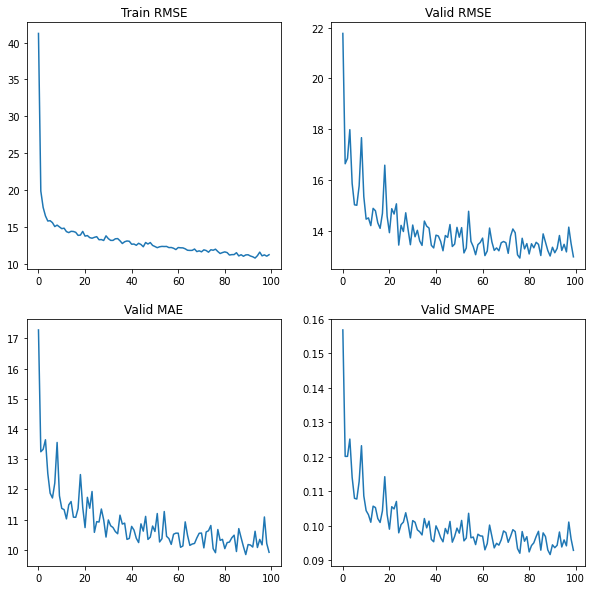

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')

In [23]:
test

NameError: name 'test' is not defined